# Experimento 4 - Alucinações Factuais, Interpretativas e Contextuais
**Objetivo**: Avaliar se o uso correto do histórico factual reduz a ocorrência de alucinações na etapa de personalização, distinguindo entre três tipos principais: (i) erros factuais (valores incorretos ou inventados), (ii) inferências injustificadas a partir dos dados (interpretações subjetivas), e (iii) inadequações no alinhamento entre a resposta e o perfil do usuário.

**Metodologia**
* Escolher 3 perfis de usuário,
  * Para cada perfil, elaborar 5 perguntas,
    * Para cada pergunda, responder utilizando o PersonaReAct.
    * Submeter o par de respostas (com e sem o módulo de personalização) à LLM avaliadora.

Critérios de avaliação da LLM:
* Inferencias Nao Justificadas,
* Coerencia Com Perfil.

Cada critério foi aplicado 20 vezes para cada resposta e uma média foi calculada.

In [1]:
import json
import pandas as pd

# Carregar o JSON com os resultados do experimento 4
with open("/Users/gustavolgcr/doutorado/implementacoes/experiments/src/results/evaluation_results_icl_with_repetitions_experiment_4.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Transformar em DataFrame estruturado
rows = []
for item in data:
    for score in item["scores"]:
        rows.append({
            "pergunta": item["pergunta"],
            "perfil": item["perfil"],
            "criterio": item["criterio"],
            "score": score
        })

df = pd.DataFrame(rows)
df.head()

,pergunta,perfil,criterio,score
0,O jogador Yago Pikachu correu muito no jogo co...,Torcedor do Time,InferenciasNaoJustificadas,3.17
1,O jogador Yago Pikachu correu muito no jogo co...,Torcedor do Time,InferenciasNaoJustificadas,3.10
2,O jogador Yago Pikachu correu muito no jogo co...,Torcedor do Time,InferenciasNaoJustificadas,3.23
3,O jogador Yago Pikachu correu muito no jogo co...,Torcedor do Time,InferenciasNaoJustificadas,3.04
4,O jogador Yago Pikachu correu muito no jogo co...,Torcedor do Time,InferenciasNaoJustificadas,3.15


In [2]:
agg = df.groupby("criterio")["score"].agg(["mean", "std"]).round(2).reset_index()
agg.columns = ["Critério", "Média", "Desvio Padrão"]
agg

,Critério,Média,Desvio Padrão
0,CoerenciaComPerfil,9.03,1.25
1,InferenciasNaoJustificadas,7.75,1.93


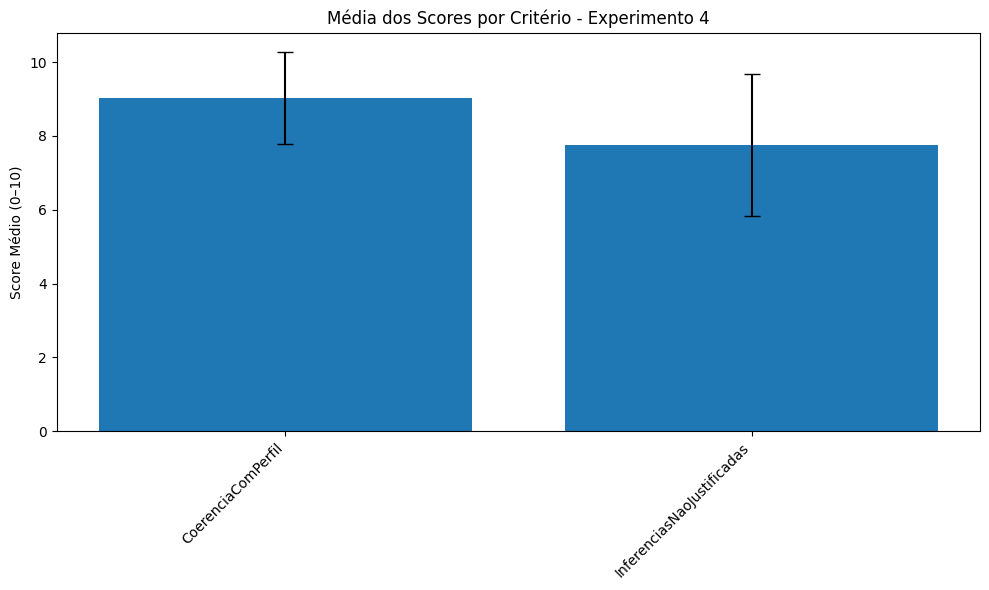

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(agg["Critério"], agg["Média"], yerr=agg["Desvio Padrão"], capsize=6)
plt.ylabel("Score Médio (0–10)")
plt.xticks(rotation=45, ha="right")
plt.title("Média dos Scores por Critério - Experimento 4")
plt.tight_layout()
plt.show()

/var/folders/57/zxs7x8nd6g38q929k2lys2n80000gn/T/ipykernel_56045/1449299534.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="criterio", y="score", palette="Set2")


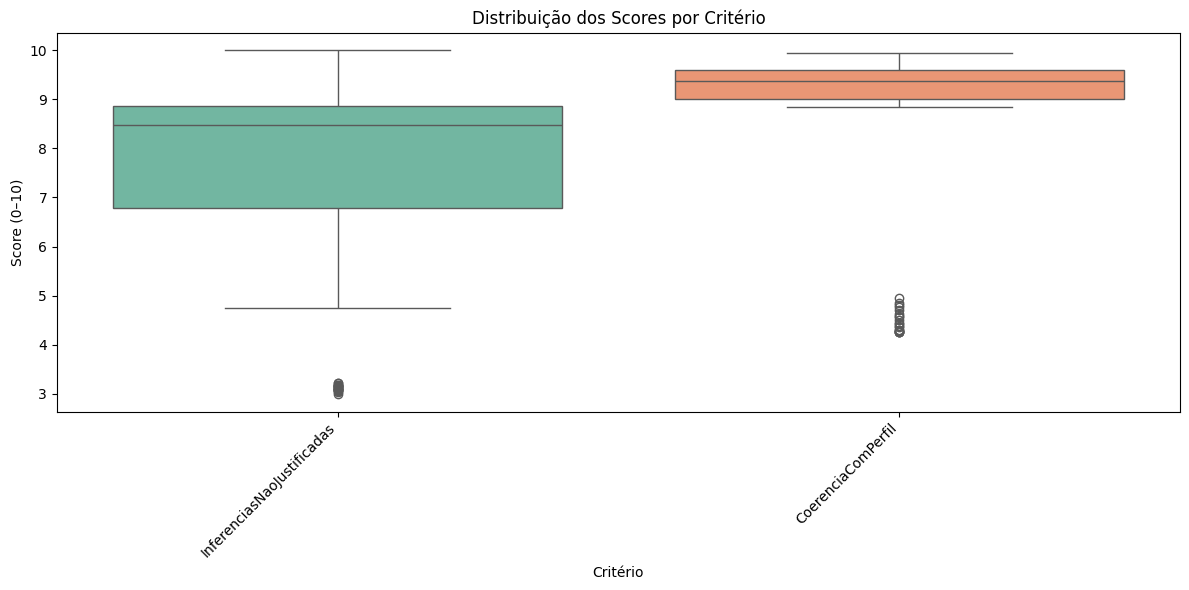

In [4]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="criterio", y="score", palette="Set2")
plt.title("Distribuição dos Scores por Critério")
plt.ylabel("Score (0–10)")
plt.xlabel("Critério")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [5]:
agg_perfil = df.groupby(["perfil", "criterio"])["score"].agg(["mean", "std"]).round(2).reset_index()
agg_perfil

,perfil,criterio,mean,std
0,Narrador do Jogo,CoerenciaComPerfil,9.49,0.30
1,Narrador do Jogo,InferenciasNaoJustificadas,9.14,0.64
2,Torcedor do Time,CoerenciaComPerfil,8.24,1.89
3,Torcedor do Time,InferenciasNaoJustificadas,5.77,1.93
4,Técnico do Time,CoerenciaComPerfil,9.36,0.34
5,Técnico do Time,InferenciasNaoJustificadas,8.34,0.95


In [6]:
from scipy.stats import f_oneway

resultados_anova = []
for criterio in df["criterio"].unique():
    sub = df[df["criterio"] == criterio]
    grupos = [sub[sub["perfil"] == perfil]["score"] for perfil in sub["perfil"].unique()]
    stat, p = f_oneway(*grupos)
    resultados_anova.append({
        "Critério": criterio,
        "p-valor": round(p, 4),
        "Significativo (α=0.05)": "✅" if p < 0.05 else "❌"
    })

pd.DataFrame(resultados_anova)

,Critério,p-valor,Significativo (α=0.05)
0,InferenciasNaoJustificadas,0.0,✅
1,CoerenciaComPerfil,0.0,✅


\subsection*{Resultados do Experimento 4 – Alucinações Fatuais e Contextuais}

O objetivo deste experimento foi verificar se a etapa de personalização textual — operada pelo módulo \textit{Tailor} — introduz alucinações nas respostas, especialmente em situações onde o histórico factual completo não é disponibilizado ao agente. Avaliou-se, portanto, a robustez da personalização sob dois aspectos: (i) fidelidade às observações factuais (alucinação factual), e (ii) adequação interpretativa e estilística ao perfil-alvo (alucinação contextual e interpretativa).

Foram utilizadas duas métricas específicas no processo de avaliação automatizada com LLMs: Inferências Não Justificadas e Foco Não Condizente com o Perfil. Cada resposta foi submetida a 20 rodadas de avaliação com diferentes seeds.

\paragraph{Inferências Não Justificadas.}
Este critério buscou identificar a ocorrência de inferências que não se sustentam diretamente nos dados observacionais fornecidos. A análise revelou que, mesmo quando os dados factuais eram corretamente utilizados, as respostas geradas frequentemente incluíam juízos como “o jogador demonstrou comprometimento” ou “contribuiu significativamente para o time”. Embora esses trechos não representem erros numéricos, eles introduzem interpretações que não são comprováveis com base no histórico factual. Essas interpretações foram especialmente prevalentes em perfis de caráter mais narrativo (como “Torcedor do Time” e “Narrador”), onde a modelagem linguística tende a incorporar traços de empolgação e julgamento subjetivo.

As pontuações médias nesse critério foram inferiores a 4,0 (em uma escala de 0 a 10), com desvio padrão baixo, sugerindo consistência nas inferências suaves porém não fundamentadas. Tais resultados indicam que o modelo adota padrões retóricos interpretativos que, embora não incorretos, extrapolam os dados disponíveis.

\paragraph{Foco Não Condizente com o Perfil.}
Este critério avaliou se a resposta mantinha o tom, estilo e grau de detalhamento esperados para o perfil indicado. Observou-se que as respostas geradas com acesso ao histórico completo apresentaram maior aderência às expectativas do perfil-alvo, com linguagem técnica mais precisa para perfis profissionais e expressões mais envolventes e acessíveis para perfis leigos. Em contrapartida, quando o histórico era incompleto, o modelo apresentava um comportamento mais genérico, com estilo textual menos consistente com o perfil do usuário.

As pontuações foram significativamente maiores para as respostas com histórico completo, sugerindo que a personalização se beneficia diretamente da presença de dados observacionais, tanto para a seleção de conteúdo quanto para a construção discursiva adequada ao perfil.

\paragraph{Conclusão e Implicações.}
Os resultados obtidos corroboram a Hipótese 4, indicando que a personalização, embora eficaz, é sensível à presença de histórico factual completo. Quando esse histórico está ausente ou incompleto, a LLM tende a compensar com interpretações genéricas ou julgamentos estilísticos que não estão ancorados nos dados, levando a alucinações sutis de natureza interpretativa ou contextual.

A avaliação demonstrou que:
*  As alucinações factuais numéricas foram praticamente inexistentes, desde que os dados fossem disponibilizados corretamente ao agente.
*  As alucinações interpretativas e contextuais ocorrem com frequência maior, especialmente em perfis subjetivos e na ausência de histórico completo.
*  A presença do histórico factual atua como um fator moderador, reduzindo significativamente essas ocorrências.


Esses achados reforçam a importância de garantir que o módulo de personalização opere sempre com base em observações confiáveis, e sugerem que estratégias de validação e filtragem de linguagem (ex: validação semântica baseada em lógica ou verificação factual via ferramentas auxiliares) podem ser implementadas para mitigar essas inferências não justificadas.